In [1]:
import torch
torch.__version__

'2.5.0+cu124'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
import numpy as np
import pandas as pd
import csv
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import AdamW
import os
from tqdm import tqdm
from sklearn.metrics import f1_score
from torchvision.models import mobilenet_v3_large
import random
import gc
import math

C:\Users\MoKha\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\MoKha\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [4]:
# Set seed for reproducibility
SEED = 123
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

## Load Data

In [5]:
class FERDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

        # Ekstrak label dan piksel
        self.labels = self.dataframe['emotion'].values
        self.pixels = self.dataframe['pixels'].apply(self.string_to_image).values

    def string_to_image(self, pixels_string):
        # Konversi string piksel menjadi numpy array dan reshape ke 48x48
        pixels = np.array(pixels_string.split(), dtype='float32')
        image = pixels.reshape(48, 48)
        image = np.expand_dims(image, axis=-1)  # Tambahkan channel dimensi
        return image

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = self.pixels[idx]
        label = self.labels[idx]
        
        image = Image.fromarray(image.squeeze().astype('uint8'), mode='L')

        # Jika ada transformasi, terapkan ke image
        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
# Create image size
IMG_SIZE = 224

# Create transform pipeline manually
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
]) 

# Create transform pipeline manually
test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

 
print(f"train transforms: {train_transforms}")
print(f"test transforms: {test_transforms}")

train transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.5], std=[0.5])
)
test transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.5], std=[0.5])
)


In [7]:
data = pd.read_csv('D://Kuliah//UPI//SEMESTER 8//dataset skripsi//fer2013v2_clean.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33303 entries, 0 to 33302
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   pixels   33303 non-null  object
 1   emotion  33303 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 520.5+ KB


In [8]:
# pisahkan data train (80%), validation (10%), test (10%)
data_train, data_test = train_test_split(data, test_size=0.1, stratify=data['emotion'], random_state=123)
data_train, data_val = train_test_split(data_train, test_size=0.1, stratify=data_train['emotion'], random_state=123)

# Cek ukuran masing-masing set untuk memastikan proporsi
print(f'Train set size: {len(data_train)}')
print(f'Validation set size: {len(data_val)}')
print(f'Test set size: {len(data_test)}')

Train set size: 26974
Validation set size: 2998
Test set size: 3331


In [9]:
train_dataset = FERDataset(data_train, transform=train_transforms)
val_dataset = FERDataset(data_val, transform=test_transforms)
test_dataset = FERDataset(data_test, transform=test_transforms)
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

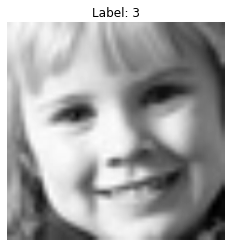

In [10]:
# Ambil satu contoh dari train_dataset
image, label = train_dataset[0]  # Index pertama dataset

# Jika transform menghasilkan tensor, konversi ke format numpy
if isinstance(image, torch.Tensor):
    image = image.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)

# Plot gambar
plt.imshow(image, cmap='gray')  # Gunakan cmap='gray' jika gambar grayscale
plt.title(f"Label: {label}")
plt.axis('off')  # Hilangkan sumbu
plt.show()

In [11]:
image, label = train_dataset[0]
image.shape

torch.Size([1, 224, 224])

## Build Vision Transformer (ViT) Model

In [12]:
from torch import nn

In [13]:
class PatchEmbedding(nn.Module):
    def __init__(self, 
                 in_channels:int=1,
                 patch_size:int=16,
                 embedding_dim:int=768
                ):
        super().__init__()
        
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
    def forward(self, x):
        image_resolution = x.shape[-1]
        
        x_patched = self.patcher(x) # (n_samples, embed_dim, n_patches ** 0.5, n_patches ** 0.5)
        x_flattened = x_patched.flatten(2) # (n_samples, embed_dim, n_patches)
        x = x_flattened.transpose(1, 2) # (n_samples, n_patches, embed_dim)
        
        return x

In [14]:
class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 attn_dropout:float=0.):
        super().__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)
    def forward(self, x):
        attn_output, _ = self.multihead_attn(query=x,
                                             key=x,
                                             value=x,
                                             need_weights=False)
        return attn_output

In [15]:
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 dropout:float=0.):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )
    def forward(self, x):
        x = self.mlp(x)
        return x

In [16]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 mlp_size:int=3072,
                 mlp_dropout:float=0.,
                 attn_dropout:float=0.):
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(normalized_shape=embedding_dim, eps=1e-6)
        
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        self.layer_norm2 = nn.LayerNorm(normalized_shape=embedding_dim, eps=1e-6)
        
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
    def forward(self, x):
        x = self.msa_block(self.layer_norm1(x)) + x 
        
        x = self.mlp_block(self.layer_norm2(x)) + x 
        
        return x

In [17]:
class ViT(nn.Module):
    def __init__(self,
                 img_size:int=224,
                 in_channels:int=3,
                 patch_size:int=16,
                 num_transformer_layers:int=12,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 num_heads:int=12,
                 attn_dropout:float=0.,
                 mlp_dropout:float=0.,
                 embedding_dropout:float=0.,
                 num_classes:int=1000):
        super().__init__()
        self.num_patches = (img_size * img_size) // patch_size**2

        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
                 
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        self.norm = nn.LayerNorm(normalized_shape=embedding_dim, eps=1e-6)
        self.head = nn.Linear(in_features=embedding_dim, out_features=num_classes)
    
    def forward(self, pixel_values, labels=None):
        batch_size = pixel_values.shape[0]

        x = self.patch_embedding(pixel_values) # (n_samples, num_patches, embed_dim)
        
        class_token = self.class_embedding.expand(batch_size, -1, -1) # (n_samples, 1, embed_dim)

        x = torch.cat((class_token, x), dim=1) # (n_samples, 1 + n_patches, embed_dim)

        x = self.position_embedding + x # add position embed

        x = self.embedding_dropout(x)

        x = self.transformer_encoder(x)

        x = self.norm(x)
        
        cls_token_final = x[:, 0]

        logits = self.head(cls_token_final)
    
        return logits

## Model Training

In [18]:
class BestModelSaver:
    def __init__(self, save_path, model_name):
        self.save_path = save_path
        self.model_name = model_name
        self.best_accuracy = -float('inf')
        os.makedirs(self.save_path, exist_ok=True)

    def save(self, model, current_accuracy, epoch):
        if current_accuracy > self.best_accuracy:
            self.best_accuracy = current_accuracy
            model_path = os.path.join(self.save_path, f"{self.model_name}_best.pt")
            torch.save(model.state_dict(), model_path)
            print(f"Best model saved at {model_path} with accuracy: {self.best_accuracy:.4f}")

In [19]:
class MetricsPlotter:
    def __init__(self, save_path, model_name):
        self.save_path = save_path
        self.model_name = model_name
        os.makedirs(self.save_path, exist_ok=True)

    def plot_and_save(self, train_metrics, val_metrics, metric_name, epoch):
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(train_metrics) + 1), train_metrics, label=f"Training {metric_name}", marker='o')
        plt.plot(range(1, len(val_metrics) + 1), val_metrics, label=f"Validation {metric_name}", marker='o')
        plt.title(f"{self.model_name} {metric_name} per Epoch")
        plt.xlabel("Epoch")
        plt.ylabel(metric_name)
        plt.legend()
        plt.grid(True)
        plot_path = os.path.join(self.save_path, f"{self.model_name}_{metric_name.lower()}.png")
        plt.savefig(plot_path)
        plt.close()

In [20]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.epochs_no_improve = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.epochs_no_improve = 0
        else:
            self.epochs_no_improve += 1

        if self.epochs_no_improve >= self.patience:
            self.early_stop = True

        return self.early_stop

In [21]:
class Validator:
    def __init__(self, model, criterion, device):
        self.model = model
        self.criterion = criterion
        self.device = device

    def validate(self, val_loader):
        self.model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        all_targets = []
        all_predicted = []

        with torch.no_grad():  # Disable gradient computation
            pbar = tqdm(val_loader, desc="Validation")
            for batch_idx, (inputs, targets) in enumerate(pbar):
                inputs, targets = inputs.to(self.device), targets.to(self.device)

                # Forward pass
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)

                # Update statistics
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()

                # Collect all targets and predictions for F1-score
                all_targets.extend(targets.cpu().numpy())
                all_predicted.extend(predicted.cpu().numpy())

                # Update progress bar
                pbar.set_postfix({
                    "Loss": f"{val_loss / (batch_idx + 1):.4f}",
                    "Acc": f"{val_correct / val_total:.4f}"
                })

        # Calculate validation accuracy, loss, and F1-score
        val_accuracy = val_correct / val_total
        avg_val_loss = val_loss / len(val_loader)
        val_f1 = f1_score(all_targets, all_predicted, average="weighted")

        return avg_val_loss, val_accuracy, val_f1

In [22]:
dropouts = [0.1, 0.3, 0.5, 0.7]

EPOCHS = 1000
LEARNING_RATE = 3e-5
NUM_CLASSES = 7
SEED = 123
BATCH_SIZE = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
# Define the CSV file paths
epoch_csv_path = "D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2//attn_dropout_epoch_results2.csv"
test_csv_path = "D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2//attn_dropout_test_results2.csv"

# Check if the epoch results CSV file exists. If not, create it and write the header.
if not os.path.exists(epoch_csv_path):
    with open(epoch_csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Attn Dropout", "Epoch", "Train Loss", "Train Acc", "Val Loss", "Val Acc", "F1 Score", "Learning Rate"])
        
# Check if the epoch results CSV file exists. If not, create it and write the header.
if not os.path.exists(test_csv_path):
    with open(test_csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Attn Dropout", "Test Loss", "Test Acc", "F1 Score"])

In [24]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=torch.Generator().manual_seed(SEED))
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, generator=torch.Generator().manual_seed(SEED))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, generator=torch.Generator().manual_seed(SEED))

# Open the configuration CSV file in append mode
with open(epoch_csv_path, mode='a', newline='') as epoch_file, \
     open(test_csv_path, mode='a', newline='') as test_file:
    
    epoch_writer = csv.writer(epoch_file)
    test_writer = csv.writer(test_file)

    idx = 1

    for dropout in dropouts:
        print(f"Start model{idx} with configuration dropout: {dropout}")

        # Model initialization
        model = ViT(num_classes=len(class_names), 
                    in_channels=1, 
                    patch_size=32, 
                    num_heads=4, 
                    embedding_dim=256, 
                    num_transformer_layers=6,
                    attn_dropout=dropout)

        model = model.to(DEVICE)

        # Initialize BestModelSaver and MetricsPlotter
        model_saver = BestModelSaver(save_path="D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2", model_name=f"model{idx}_dropout")
        metrics_plotter = MetricsPlotter(save_path="D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2", model_name=f"model{idx}_dropout")

        optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
        criterion = nn.CrossEntropyLoss()

        # Define the learning rate scheduler
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
        early_stopping = EarlyStopping(patience=15, min_delta=0)

        # Initialize Validator
        validator = Validator(model=model, criterion=criterion, device=DEVICE)

        # Initialize lists to store training and validation metrics
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        for epoch in range(EPOCHS):
            model.train()
            train_loss = 0.0
            correct = 0
            total = 0

            # Training
            pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS}")
            for batch_idx, (inputs, targets) in enumerate(pbar):
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

                # Zero the gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                # Backward pass and optimize
                loss.backward()
                optimizer.step()

                # Update statistics
                train_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

                # Update progress bar
                pbar.set_postfix({
                    "Loss": f"{train_loss / (batch_idx + 1):.4f}",
                    "Acc": f"{correct / total:.4f}"
                })

            # Calculate training accuracy and loss
            train_accuracy = correct / total
            avg_train_loss = train_loss / len(train_loader)
            train_losses.append(avg_train_loss)
            train_accuracies.append(train_accuracy)

            # Print training summary
            print(f"Epoch {epoch + 1}/{EPOCHS}: "
                  f"Train Loss: {avg_train_loss:.4f}, "
                  f"Train Acc: {train_accuracy:.4f}")

            # ===== VALIDATION =======
            avg_val_loss, val_accuracy, val_f1 = validator.validate(val_loader)
            val_losses.append(avg_val_loss)
            val_accuracies.append(val_accuracy)

            # Print validation summary
            print(f"Epoch {epoch + 1}/{EPOCHS}: "
                  f"Val Loss: {avg_val_loss:.4f}, "
                  f"Val Acc: {val_accuracy:.4f}, "
                  f"Val F1: {val_f1:.4f}")

            # Step the learning rate scheduler based on validation loss
            scheduler.step(avg_val_loss)

            # Print the current learning rate
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Current Learning Rate: {current_lr}")

            # Save the best model based on validation accuracy
            model_saver.save(model, val_accuracy, epoch)

            # Save loss and accuracy plots
            metrics_plotter.plot_and_save(train_losses, val_losses, "Loss", epoch)
            metrics_plotter.plot_and_save(train_accuracies, val_accuracies, "Accuracy", epoch)

            # Save epoch results to CSV
            epoch_writer.writerow([
                dropout,  # Config
                epoch + 1,  # Epoch
                avg_train_loss,  # Train Loss
                train_accuracy,  # Train Acc
                avg_val_loss,  # Val Loss
                val_accuracy,  # Val Acc
                val_f1,  # F1 Score
                current_lr  # Learning Rate
            ])

            # Early stopping check
            if early_stopping(avg_val_loss):
                print(f"Early stopping triggered at epoch {epoch + 1}!")
                break

        # Clear GPU memory after each configuration
        del model, optimizer, scheduler
        torch.cuda.empty_cache()
        gc.collect()

        # ======= TESTING ========
        best_model = ViT(num_classes=len(class_names), 
                            in_channels=1, 
                            patch_size=32, 
                            num_heads=4, 
                            embedding_dim=256, 
                            num_transformer_layers=6,
                            attn_dropout=dropout)
        best_model.to(DEVICE)
        best_model.load_state_dict(torch.load(f"D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2//model{idx}_dropout_best.pt", weights_only=False))

        best_model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        all_test_targets = []
        all_test_predicted = []

        with torch.no_grad():  # Disable gradient computation
            pbar = tqdm(test_loader, desc="Testing")
            for batch_idx, (inputs, targets) in enumerate(pbar):
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

                # Forward pass
                outputs = best_model(inputs)
                loss = criterion(outputs, targets)

                # Update statistics
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                test_total += targets.size(0)
                test_correct += predicted.eq(targets).sum().item()

                # Collect all targets and predictions
                all_test_targets.extend(targets.cpu().numpy())
                all_test_predicted.extend(predicted.cpu().numpy())

                # Update progress bar
                pbar.set_postfix({
                    "Loss": f"{test_loss / (batch_idx + 1):.4f}",
                    "Acc": f"{test_correct / test_total:.4f}"
                })

        # Calculate test accuracy, loss, and F1-score
        test_accuracy = test_correct / test_total
        avg_test_loss = test_loss / len(test_loader)
        test_f1 = f1_score(all_test_targets, all_test_predicted, average="weighted")

        # Print test summary
        print(f"Test Loss: {avg_test_loss:.4f}, "
              f"Test Acc: {test_accuracy:.4f}, "
              f"Test F1: {test_f1:.4f}")

        # Clear GPU memory after each configuration
        del best_model
        torch.cuda.empty_cache()
        gc.collect()

        # Save the configuration to the CSV file
        test_writer.writerow([dropout, avg_test_loss, test_accuracy, test_f1])

        idx+=1

Start model1 with configuration dropout: 0.1


Epoch 1/1000: 100%|█████████████████████████████████████████| 422/422 [00:36<00:00, 11.48it/s, Loss=1.7663, Acc=0.2633]


Epoch 1/1000: Train Loss: 1.7663, Train Acc: 0.2633


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:01<00:00, 23.65it/s, Loss=1.6888, Acc=0.3192]


Epoch 1/1000: Val Loss: 1.6888, Val Acc: 0.3192, Val F1: 0.2267
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model1_dropout_best.pt with accuracy: 0.3192


Epoch 2/1000: 100%|█████████████████████████████████████████| 422/422 [00:37<00:00, 11.24it/s, Loss=1.6442, Acc=0.3550]


Epoch 2/1000: Train Loss: 1.6442, Train Acc: 0.3550


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 20.18it/s, Loss=1.6097, Acc=0.3689]


Epoch 2/1000: Val Loss: 1.6097, Val Acc: 0.3689, Val F1: 0.3320
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model1_dropout_best.pt with accuracy: 0.3689


Epoch 3/1000: 100%|█████████████████████████████████████████| 422/422 [00:38<00:00, 10.97it/s, Loss=1.5877, Acc=0.3783]


Epoch 3/1000: Train Loss: 1.5877, Train Acc: 0.3783


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 21.43it/s, Loss=1.5726, Acc=0.3869]


Epoch 3/1000: Val Loss: 1.5726, Val Acc: 0.3869, Val F1: 0.3511
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model1_dropout_best.pt with accuracy: 0.3869


Epoch 4/1000: 100%|█████████████████████████████████████████| 422/422 [00:39<00:00, 10.81it/s, Loss=1.5456, Acc=0.3960]


Epoch 4/1000: Train Loss: 1.5456, Train Acc: 0.3960


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 20.19it/s, Loss=1.5371, Acc=0.4039]


Epoch 4/1000: Val Loss: 1.5371, Val Acc: 0.4039, Val F1: 0.3757
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model1_dropout_best.pt with accuracy: 0.4039


Epoch 5/1000: 100%|█████████████████████████████████████████| 422/422 [00:40<00:00, 10.49it/s, Loss=1.5162, Acc=0.4102]


Epoch 5/1000: Train Loss: 1.5162, Train Acc: 0.4102


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 20.15it/s, Loss=1.5394, Acc=0.4083]


Epoch 5/1000: Val Loss: 1.5394, Val Acc: 0.4083, Val F1: 0.3992
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model1_dropout_best.pt with accuracy: 0.4083


Epoch 6/1000: 100%|█████████████████████████████████████████| 422/422 [00:40<00:00, 10.53it/s, Loss=1.4871, Acc=0.4221]


Epoch 6/1000: Train Loss: 1.4871, Train Acc: 0.4221


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 18.92it/s, Loss=1.4997, Acc=0.4239]


Epoch 6/1000: Val Loss: 1.4997, Val Acc: 0.4239, Val F1: 0.3864
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model1_dropout_best.pt with accuracy: 0.4239


Epoch 7/1000: 100%|█████████████████████████████████████████| 422/422 [00:39<00:00, 10.61it/s, Loss=1.4611, Acc=0.4293]


Epoch 7/1000: Train Loss: 1.4611, Train Acc: 0.4293


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 19.96it/s, Loss=1.4932, Acc=0.4209]


Epoch 7/1000: Val Loss: 1.4932, Val Acc: 0.4209, Val F1: 0.3906
Current Learning Rate: 3e-05


Epoch 8/1000: 100%|█████████████████████████████████████████| 422/422 [00:39<00:00, 10.59it/s, Loss=1.4315, Acc=0.4439]


Epoch 8/1000: Train Loss: 1.4315, Train Acc: 0.4439


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 19.64it/s, Loss=1.4750, Acc=0.4286]


Epoch 8/1000: Val Loss: 1.4750, Val Acc: 0.4286, Val F1: 0.4129
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model1_dropout_best.pt with accuracy: 0.4286


Epoch 9/1000: 100%|█████████████████████████████████████████| 422/422 [00:39<00:00, 10.61it/s, Loss=1.4010, Acc=0.4560]


Epoch 9/1000: Train Loss: 1.4010, Train Acc: 0.4560


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 19.47it/s, Loss=1.4797, Acc=0.4300]


Epoch 9/1000: Val Loss: 1.4797, Val Acc: 0.4300, Val F1: 0.4240
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model1_dropout_best.pt with accuracy: 0.4300


Epoch 10/1000: 100%|████████████████████████████████████████| 422/422 [00:39<00:00, 10.59it/s, Loss=1.3655, Acc=0.4721]


Epoch 10/1000: Train Loss: 1.3655, Train Acc: 0.4721


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 18.33it/s, Loss=1.4529, Acc=0.4363]


Epoch 10/1000: Val Loss: 1.4529, Val Acc: 0.4363, Val F1: 0.4139
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model1_dropout_best.pt with accuracy: 0.4363


Epoch 11/1000: 100%|████████████████████████████████████████| 422/422 [00:40<00:00, 10.50it/s, Loss=1.3296, Acc=0.4869]


Epoch 11/1000: Train Loss: 1.3296, Train Acc: 0.4869


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 18.36it/s, Loss=1.4628, Acc=0.4426]


Epoch 11/1000: Val Loss: 1.4628, Val Acc: 0.4426, Val F1: 0.4256
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model1_dropout_best.pt with accuracy: 0.4426


Epoch 12/1000: 100%|████████████████████████████████████████| 422/422 [00:40<00:00, 10.54it/s, Loss=1.2872, Acc=0.5059]


Epoch 12/1000: Train Loss: 1.2872, Train Acc: 0.5059


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 18.89it/s, Loss=1.4506, Acc=0.4463]


Epoch 12/1000: Val Loss: 1.4506, Val Acc: 0.4463, Val F1: 0.4236
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model1_dropout_best.pt with accuracy: 0.4463


Epoch 13/1000: 100%|████████████████████████████████████████| 422/422 [00:40<00:00, 10.50it/s, Loss=1.2367, Acc=0.5257]


Epoch 13/1000: Train Loss: 1.2367, Train Acc: 0.5257


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 18.99it/s, Loss=1.4515, Acc=0.4503]


Epoch 13/1000: Val Loss: 1.4515, Val Acc: 0.4503, Val F1: 0.4226
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model1_dropout_best.pt with accuracy: 0.4503


Epoch 14/1000: 100%|████████████████████████████████████████| 422/422 [00:40<00:00, 10.42it/s, Loss=1.1851, Acc=0.5484]


Epoch 14/1000: Train Loss: 1.1851, Train Acc: 0.5484


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 19.60it/s, Loss=1.4985, Acc=0.4350]


Epoch 14/1000: Val Loss: 1.4985, Val Acc: 0.4350, Val F1: 0.4325
Current Learning Rate: 3e-05


Epoch 15/1000: 100%|████████████████████████████████████████| 422/422 [00:40<00:00, 10.55it/s, Loss=1.1263, Acc=0.5699]


Epoch 15/1000: Train Loss: 1.1263, Train Acc: 0.5699


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 18.96it/s, Loss=1.4882, Acc=0.4556]


Epoch 15/1000: Val Loss: 1.4882, Val Acc: 0.4556, Val F1: 0.4284
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model1_dropout_best.pt with accuracy: 0.4556


Epoch 16/1000: 100%|████████████████████████████████████████| 422/422 [00:40<00:00, 10.53it/s, Loss=1.0555, Acc=0.6048]


Epoch 16/1000: Train Loss: 1.0555, Train Acc: 0.6048


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 19.92it/s, Loss=1.5225, Acc=0.4440]


Epoch 16/1000: Val Loss: 1.5225, Val Acc: 0.4440, Val F1: 0.4434
Current Learning Rate: 3e-05


Epoch 17/1000: 100%|████████████████████████████████████████| 422/422 [00:40<00:00, 10.54it/s, Loss=0.9809, Acc=0.6322]


Epoch 17/1000: Train Loss: 0.9809, Train Acc: 0.6322


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 20.05it/s, Loss=1.5420, Acc=0.4473]


Epoch 17/1000: Val Loss: 1.5420, Val Acc: 0.4473, Val F1: 0.4353
Current Learning Rate: 3e-05


Epoch 18/1000: 100%|████████████████████████████████████████| 422/422 [00:39<00:00, 10.64it/s, Loss=0.8935, Acc=0.6719]


Epoch 18/1000: Train Loss: 0.8935, Train Acc: 0.6719


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 18.79it/s, Loss=1.5984, Acc=0.4490]


Epoch 18/1000: Val Loss: 1.5984, Val Acc: 0.4490, Val F1: 0.4475
Current Learning Rate: 3e-06


Epoch 19/1000: 100%|████████████████████████████████████████| 422/422 [00:40<00:00, 10.36it/s, Loss=0.6692, Acc=0.7709]


Epoch 19/1000: Train Loss: 0.6692, Train Acc: 0.7709


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 18.95it/s, Loss=1.6783, Acc=0.4586]


Epoch 19/1000: Val Loss: 1.6783, Val Acc: 0.4586, Val F1: 0.4560
Current Learning Rate: 3e-06
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model1_dropout_best.pt with accuracy: 0.4586


Epoch 20/1000: 100%|████████████████████████████████████████| 422/422 [00:41<00:00, 10.28it/s, Loss=0.6097, Acc=0.7959]


Epoch 20/1000: Train Loss: 0.6097, Train Acc: 0.7959


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 19.37it/s, Loss=1.7311, Acc=0.4590]


Epoch 20/1000: Val Loss: 1.7311, Val Acc: 0.4590, Val F1: 0.4582
Current Learning Rate: 3e-06
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model1_dropout_best.pt with accuracy: 0.4590


Epoch 21/1000: 100%|████████████████████████████████████████| 422/422 [00:40<00:00, 10.45it/s, Loss=0.5764, Acc=0.8069]


Epoch 21/1000: Train Loss: 0.5764, Train Acc: 0.8069


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 18.17it/s, Loss=1.7789, Acc=0.4586]


Epoch 21/1000: Val Loss: 1.7789, Val Acc: 0.4586, Val F1: 0.4542
Current Learning Rate: 3e-06


Epoch 22/1000: 100%|████████████████████████████████████████| 422/422 [00:39<00:00, 10.56it/s, Loss=0.5475, Acc=0.8188]


Epoch 22/1000: Train Loss: 0.5475, Train Acc: 0.8188


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 19.92it/s, Loss=1.8160, Acc=0.4536]


Epoch 22/1000: Val Loss: 1.8160, Val Acc: 0.4536, Val F1: 0.4512
Current Learning Rate: 3e-06


Epoch 23/1000: 100%|████████████████████████████████████████| 422/422 [00:40<00:00, 10.53it/s, Loss=0.5213, Acc=0.8287]


Epoch 23/1000: Train Loss: 0.5213, Train Acc: 0.8287


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 19.50it/s, Loss=1.8658, Acc=0.4603]


Epoch 23/1000: Val Loss: 1.8658, Val Acc: 0.4603, Val F1: 0.4581
Current Learning Rate: 3e-06
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model1_dropout_best.pt with accuracy: 0.4603


Epoch 24/1000: 100%|████████████████████████████████████████| 422/422 [00:40<00:00, 10.54it/s, Loss=0.4964, Acc=0.8387]


Epoch 24/1000: Train Loss: 0.4964, Train Acc: 0.8387


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 17.63it/s, Loss=1.9265, Acc=0.4563]


Epoch 24/1000: Val Loss: 1.9265, Val Acc: 0.4563, Val F1: 0.4507
Current Learning Rate: 3.0000000000000004e-07


Epoch 25/1000: 100%|████████████████████████████████████████| 422/422 [00:41<00:00, 10.18it/s, Loss=0.4589, Acc=0.8562]


Epoch 25/1000: Train Loss: 0.4589, Train Acc: 0.8562


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:03<00:00, 15.63it/s, Loss=1.9254, Acc=0.4556]


Epoch 25/1000: Val Loss: 1.9254, Val Acc: 0.4556, Val F1: 0.4531
Current Learning Rate: 3.0000000000000004e-07


Epoch 26/1000: 100%|████████████████████████████████████████| 422/422 [00:40<00:00, 10.45it/s, Loss=0.4542, Acc=0.8582]


Epoch 26/1000: Train Loss: 0.4542, Train Acc: 0.8582


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 18.36it/s, Loss=1.9333, Acc=0.4566]


Epoch 26/1000: Val Loss: 1.9333, Val Acc: 0.4566, Val F1: 0.4533
Current Learning Rate: 3.0000000000000004e-07


Epoch 27/1000: 100%|████████████████████████████████████████| 422/422 [00:41<00:00, 10.24it/s, Loss=0.4512, Acc=0.8602]


Epoch 27/1000: Train Loss: 0.4512, Train Acc: 0.8602


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 18.05it/s, Loss=1.9396, Acc=0.4566]


Epoch 27/1000: Val Loss: 1.9396, Val Acc: 0.4566, Val F1: 0.4526
Current Learning Rate: 3.0000000000000004e-07
Early stopping triggered at epoch 27!


Testing: 100%|████████████████████████████████████████████████| 53/53 [00:03<00:00, 16.54it/s, Loss=1.8030, Acc=0.4578]


Test Loss: 1.8030, Test Acc: 0.4578, Test F1: 0.4556
Start model2 with configuration dropout: 0.3


Epoch 1/1000: 100%|█████████████████████████████████████████| 422/422 [00:40<00:00, 10.34it/s, Loss=1.7580, Acc=0.2742]


Epoch 1/1000: Train Loss: 1.7580, Train Acc: 0.2742


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 19.56it/s, Loss=1.7206, Acc=0.3089]


Epoch 1/1000: Val Loss: 1.7206, Val Acc: 0.3089, Val F1: 0.2628
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model2_dropout_best.pt with accuracy: 0.3089


Epoch 2/1000: 100%|█████████████████████████████████████████| 422/422 [00:40<00:00, 10.39it/s, Loss=1.6415, Acc=0.3510]


Epoch 2/1000: Train Loss: 1.6415, Train Acc: 0.3510


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 19.18it/s, Loss=1.6155, Acc=0.3749]


Epoch 2/1000: Val Loss: 1.6155, Val Acc: 0.3749, Val F1: 0.3133
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model2_dropout_best.pt with accuracy: 0.3749


Epoch 3/1000: 100%|█████████████████████████████████████████| 422/422 [00:40<00:00, 10.41it/s, Loss=1.5805, Acc=0.3827]


Epoch 3/1000: Train Loss: 1.5805, Train Acc: 0.3827


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 18.72it/s, Loss=1.5705, Acc=0.3993]


Epoch 3/1000: Val Loss: 1.5705, Val Acc: 0.3993, Val F1: 0.3328
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model2_dropout_best.pt with accuracy: 0.3993


Epoch 4/1000: 100%|█████████████████████████████████████████| 422/422 [00:40<00:00, 10.35it/s, Loss=1.5377, Acc=0.4007]


Epoch 4/1000: Train Loss: 1.5377, Train Acc: 0.4007


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 18.47it/s, Loss=1.5329, Acc=0.4076]


Epoch 4/1000: Val Loss: 1.5329, Val Acc: 0.4076, Val F1: 0.3805
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model2_dropout_best.pt with accuracy: 0.4076


Epoch 5/1000: 100%|█████████████████████████████████████████| 422/422 [00:40<00:00, 10.49it/s, Loss=1.5071, Acc=0.4177]


Epoch 5/1000: Train Loss: 1.5071, Train Acc: 0.4177


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 19.06it/s, Loss=1.5249, Acc=0.4059]


Epoch 5/1000: Val Loss: 1.5249, Val Acc: 0.4059, Val F1: 0.3725
Current Learning Rate: 3e-05


Epoch 6/1000: 100%|█████████████████████████████████████████| 422/422 [00:40<00:00, 10.30it/s, Loss=1.4795, Acc=0.4241]


Epoch 6/1000: Train Loss: 1.4795, Train Acc: 0.4241


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 17.94it/s, Loss=1.5066, Acc=0.4203]


Epoch 6/1000: Val Loss: 1.5066, Val Acc: 0.4203, Val F1: 0.4070
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model2_dropout_best.pt with accuracy: 0.4203


Epoch 7/1000: 100%|█████████████████████████████████████████| 422/422 [00:40<00:00, 10.32it/s, Loss=1.4516, Acc=0.4355]


Epoch 7/1000: Train Loss: 1.4516, Train Acc: 0.4355


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 19.41it/s, Loss=1.4718, Acc=0.4260]


Epoch 7/1000: Val Loss: 1.4718, Val Acc: 0.4260, Val F1: 0.4084
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model2_dropout_best.pt with accuracy: 0.4260


Epoch 8/1000: 100%|█████████████████████████████████████████| 422/422 [00:41<00:00, 10.28it/s, Loss=1.4249, Acc=0.4489]


Epoch 8/1000: Train Loss: 1.4249, Train Acc: 0.4489


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 16.04it/s, Loss=1.4599, Acc=0.4406]


Epoch 8/1000: Val Loss: 1.4599, Val Acc: 0.4406, Val F1: 0.4071
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model2_dropout_best.pt with accuracy: 0.4406


Epoch 9/1000: 100%|█████████████████████████████████████████| 422/422 [00:40<00:00, 10.39it/s, Loss=1.3954, Acc=0.4580]


Epoch 9/1000: Train Loss: 1.3954, Train Acc: 0.4580


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 19.61it/s, Loss=1.4708, Acc=0.4313]


Epoch 9/1000: Val Loss: 1.4708, Val Acc: 0.4313, Val F1: 0.4235
Current Learning Rate: 3e-05


Epoch 10/1000: 100%|████████████████████████████████████████| 422/422 [00:41<00:00, 10.24it/s, Loss=1.3592, Acc=0.4773]


Epoch 10/1000: Train Loss: 1.3592, Train Acc: 0.4773


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 17.30it/s, Loss=1.4407, Acc=0.4446]


Epoch 10/1000: Val Loss: 1.4407, Val Acc: 0.4446, Val F1: 0.4246
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model2_dropout_best.pt with accuracy: 0.4446


Epoch 11/1000: 100%|████████████████████████████████████████| 422/422 [00:40<00:00, 10.40it/s, Loss=1.3198, Acc=0.4919]


Epoch 11/1000: Train Loss: 1.3198, Train Acc: 0.4919


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 17.06it/s, Loss=1.4366, Acc=0.4446]


Epoch 11/1000: Val Loss: 1.4366, Val Acc: 0.4446, Val F1: 0.4334
Current Learning Rate: 3e-05


Epoch 12/1000: 100%|████████████████████████████████████████| 422/422 [00:41<00:00, 10.24it/s, Loss=1.2790, Acc=0.5063]


Epoch 12/1000: Train Loss: 1.2790, Train Acc: 0.5063


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 18.81it/s, Loss=1.4560, Acc=0.4460]


Epoch 12/1000: Val Loss: 1.4560, Val Acc: 0.4460, Val F1: 0.4292
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model2_dropout_best.pt with accuracy: 0.4460


Epoch 13/1000: 100%|████████████████████████████████████████| 422/422 [00:41<00:00, 10.26it/s, Loss=1.2246, Acc=0.5294]


Epoch 13/1000: Train Loss: 1.2246, Train Acc: 0.5294


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 21.09it/s, Loss=1.4500, Acc=0.4346]


Epoch 13/1000: Val Loss: 1.4500, Val Acc: 0.4346, Val F1: 0.4264
Current Learning Rate: 3e-05


Epoch 14/1000: 100%|████████████████████████████████████████| 422/422 [00:39<00:00, 10.67it/s, Loss=1.1685, Acc=0.5539]


Epoch 14/1000: Train Loss: 1.1685, Train Acc: 0.5539


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 17.89it/s, Loss=1.4514, Acc=0.4543]


Epoch 14/1000: Val Loss: 1.4514, Val Acc: 0.4543, Val F1: 0.4334
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model2_dropout_best.pt with accuracy: 0.4543


Epoch 15/1000: 100%|████████████████████████████████████████| 422/422 [00:39<00:00, 10.72it/s, Loss=1.0987, Acc=0.5843]


Epoch 15/1000: Train Loss: 1.0987, Train Acc: 0.5843


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 19.63it/s, Loss=1.4888, Acc=0.4563]


Epoch 15/1000: Val Loss: 1.4888, Val Acc: 0.4563, Val F1: 0.4472
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model2_dropout_best.pt with accuracy: 0.4563


Epoch 16/1000: 100%|████████████████████████████████████████| 422/422 [00:39<00:00, 10.63it/s, Loss=1.0340, Acc=0.6081]


Epoch 16/1000: Train Loss: 1.0340, Train Acc: 0.6081


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 18.94it/s, Loss=1.5041, Acc=0.4526]


Epoch 16/1000: Val Loss: 1.5041, Val Acc: 0.4526, Val F1: 0.4495
Current Learning Rate: 3e-05


Epoch 17/1000: 100%|████████████████████████████████████████| 422/422 [00:41<00:00, 10.22it/s, Loss=0.9495, Acc=0.6437]


Epoch 17/1000: Train Loss: 0.9495, Train Acc: 0.6437


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 19.04it/s, Loss=1.5628, Acc=0.4410]


Epoch 17/1000: Val Loss: 1.5628, Val Acc: 0.4410, Val F1: 0.4351
Current Learning Rate: 3e-06


Epoch 18/1000: 100%|████████████████████████████████████████| 422/422 [00:41<00:00, 10.07it/s, Loss=0.7395, Acc=0.7415]


Epoch 18/1000: Train Loss: 0.7395, Train Acc: 0.7415


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:03<00:00, 15.65it/s, Loss=1.5948, Acc=0.4556]


Epoch 18/1000: Val Loss: 1.5948, Val Acc: 0.4556, Val F1: 0.4520
Current Learning Rate: 3e-06


Epoch 19/1000: 100%|████████████████████████████████████████| 422/422 [00:40<00:00, 10.38it/s, Loss=0.6836, Acc=0.7667]


Epoch 19/1000: Train Loss: 0.6836, Train Acc: 0.7667


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 18.10it/s, Loss=1.6345, Acc=0.4556]


Epoch 19/1000: Val Loss: 1.6345, Val Acc: 0.4556, Val F1: 0.4521
Current Learning Rate: 3e-06


Epoch 20/1000: 100%|████████████████████████████████████████| 422/422 [00:40<00:00, 10.50it/s, Loss=0.6524, Acc=0.7770]


Epoch 20/1000: Train Loss: 0.6524, Train Acc: 0.7770


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 16.43it/s, Loss=1.6808, Acc=0.4540]


Epoch 20/1000: Val Loss: 1.6808, Val Acc: 0.4540, Val F1: 0.4500
Current Learning Rate: 3e-06


Epoch 21/1000: 100%|████████████████████████████████████████| 422/422 [00:41<00:00, 10.28it/s, Loss=0.6243, Acc=0.7873]


Epoch 21/1000: Train Loss: 0.6243, Train Acc: 0.7873


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 18.09it/s, Loss=1.7209, Acc=0.4493]


Epoch 21/1000: Val Loss: 1.7209, Val Acc: 0.4493, Val F1: 0.4481
Current Learning Rate: 3e-06


Epoch 22/1000: 100%|████████████████████████████████████████| 422/422 [00:40<00:00, 10.30it/s, Loss=0.5985, Acc=0.7977]


Epoch 22/1000: Train Loss: 0.5985, Train Acc: 0.7977


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 18.71it/s, Loss=1.7547, Acc=0.4493]


Epoch 22/1000: Val Loss: 1.7547, Val Acc: 0.4493, Val F1: 0.4476
Current Learning Rate: 3e-06


Epoch 23/1000: 100%|████████████████████████████████████████| 422/422 [00:40<00:00, 10.31it/s, Loss=0.5733, Acc=0.8071]


Epoch 23/1000: Train Loss: 0.5733, Train Acc: 0.8071


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 18.09it/s, Loss=1.7824, Acc=0.4503]


Epoch 23/1000: Val Loss: 1.7824, Val Acc: 0.4503, Val F1: 0.4485
Current Learning Rate: 3.0000000000000004e-07


Epoch 24/1000: 100%|████████████████████████████████████████| 422/422 [00:40<00:00, 10.36it/s, Loss=0.5364, Acc=0.8248]


Epoch 24/1000: Train Loss: 0.5364, Train Acc: 0.8248


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 18.61it/s, Loss=1.7972, Acc=0.4480]


Epoch 24/1000: Val Loss: 1.7972, Val Acc: 0.4480, Val F1: 0.4460
Current Learning Rate: 3.0000000000000004e-07


Epoch 25/1000: 100%|████████████████████████████████████████| 422/422 [00:41<00:00, 10.29it/s, Loss=0.5316, Acc=0.8276]


Epoch 25/1000: Train Loss: 0.5316, Train Acc: 0.8276


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 18.55it/s, Loss=1.8035, Acc=0.4473]


Epoch 25/1000: Val Loss: 1.8035, Val Acc: 0.4473, Val F1: 0.4449
Current Learning Rate: 3.0000000000000004e-07


Epoch 26/1000: 100%|████████████████████████████████████████| 422/422 [00:40<00:00, 10.33it/s, Loss=0.5284, Acc=0.8286]


Epoch 26/1000: Train Loss: 0.5284, Train Acc: 0.8286


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 18.53it/s, Loss=1.8097, Acc=0.4480]


Epoch 26/1000: Val Loss: 1.8097, Val Acc: 0.4480, Val F1: 0.4451
Current Learning Rate: 3.0000000000000004e-07
Early stopping triggered at epoch 26!


Testing: 100%|████████████████████████████████████████████████| 53/53 [00:03<00:00, 17.63it/s, Loss=1.4778, Acc=0.4578]


Test Loss: 1.4778, Test Acc: 0.4578, Test F1: 0.4481
Start model3 with configuration dropout: 0.5


Epoch 1/1000: 100%|█████████████████████████████████████████| 422/422 [00:40<00:00, 10.34it/s, Loss=1.7560, Acc=0.2789]


Epoch 1/1000: Train Loss: 1.7560, Train Acc: 0.2789


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 18.63it/s, Loss=1.7118, Acc=0.3119]


Epoch 1/1000: Val Loss: 1.7118, Val Acc: 0.3119, Val F1: 0.2466
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model3_dropout_best.pt with accuracy: 0.3119


Epoch 2/1000: 100%|█████████████████████████████████████████| 422/422 [00:41<00:00, 10.28it/s, Loss=1.6453, Acc=0.3526]


Epoch 2/1000: Train Loss: 1.6453, Train Acc: 0.3526


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 18.73it/s, Loss=1.6166, Acc=0.3719]


Epoch 2/1000: Val Loss: 1.6166, Val Acc: 0.3719, Val F1: 0.3454
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model3_dropout_best.pt with accuracy: 0.3719


Epoch 3/1000: 100%|█████████████████████████████████████████| 422/422 [00:40<00:00, 10.31it/s, Loss=1.5833, Acc=0.3803]


Epoch 3/1000: Train Loss: 1.5833, Train Acc: 0.3803


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 18.75it/s, Loss=1.5936, Acc=0.3756]


Epoch 3/1000: Val Loss: 1.5936, Val Acc: 0.3756, Val F1: 0.3401
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model3_dropout_best.pt with accuracy: 0.3756


Epoch 4/1000: 100%|█████████████████████████████████████████| 422/422 [00:40<00:00, 10.36it/s, Loss=1.5437, Acc=0.3969]


Epoch 4/1000: Train Loss: 1.5437, Train Acc: 0.3969


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 18.08it/s, Loss=1.5518, Acc=0.3896]


Epoch 4/1000: Val Loss: 1.5518, Val Acc: 0.3896, Val F1: 0.3711
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model3_dropout_best.pt with accuracy: 0.3896


Epoch 5/1000: 100%|█████████████████████████████████████████| 422/422 [00:40<00:00, 10.36it/s, Loss=1.5091, Acc=0.4114]


Epoch 5/1000: Train Loss: 1.5091, Train Acc: 0.4114


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 18.29it/s, Loss=1.5183, Acc=0.4089]


Epoch 5/1000: Val Loss: 1.5183, Val Acc: 0.4089, Val F1: 0.3852
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model3_dropout_best.pt with accuracy: 0.4089


Epoch 6/1000: 100%|█████████████████████████████████████████| 422/422 [00:41<00:00, 10.28it/s, Loss=1.4801, Acc=0.4234]


Epoch 6/1000: Train Loss: 1.4801, Train Acc: 0.4234


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 18.94it/s, Loss=1.4966, Acc=0.4169]


Epoch 6/1000: Val Loss: 1.4966, Val Acc: 0.4169, Val F1: 0.3711
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model3_dropout_best.pt with accuracy: 0.4169


Epoch 7/1000: 100%|█████████████████████████████████████████| 422/422 [00:42<00:00, 10.00it/s, Loss=1.4504, Acc=0.4363]


Epoch 7/1000: Train Loss: 1.4504, Train Acc: 0.4363


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 17.16it/s, Loss=1.4720, Acc=0.4306]


Epoch 7/1000: Val Loss: 1.4720, Val Acc: 0.4306, Val F1: 0.4166
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model3_dropout_best.pt with accuracy: 0.4306


Epoch 8/1000: 100%|█████████████████████████████████████████| 422/422 [00:41<00:00, 10.22it/s, Loss=1.4219, Acc=0.4503]


Epoch 8/1000: Train Loss: 1.4219, Train Acc: 0.4503


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 18.75it/s, Loss=1.4548, Acc=0.4373]


Epoch 8/1000: Val Loss: 1.4548, Val Acc: 0.4373, Val F1: 0.4021
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model3_dropout_best.pt with accuracy: 0.4373


Epoch 9/1000: 100%|█████████████████████████████████████████| 422/422 [00:40<00:00, 10.33it/s, Loss=1.3835, Acc=0.4652]


Epoch 9/1000: Train Loss: 1.3835, Train Acc: 0.4652


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 18.66it/s, Loss=1.4415, Acc=0.4463]


Epoch 9/1000: Val Loss: 1.4415, Val Acc: 0.4463, Val F1: 0.4326
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model3_dropout_best.pt with accuracy: 0.4463


Epoch 10/1000: 100%|████████████████████████████████████████| 422/422 [00:41<00:00, 10.24it/s, Loss=1.3510, Acc=0.4776]


Epoch 10/1000: Train Loss: 1.3510, Train Acc: 0.4776


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 18.65it/s, Loss=1.4223, Acc=0.4530]


Epoch 10/1000: Val Loss: 1.4223, Val Acc: 0.4530, Val F1: 0.4392
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model3_dropout_best.pt with accuracy: 0.4530


Epoch 11/1000: 100%|████████████████████████████████████████| 422/422 [00:41<00:00, 10.17it/s, Loss=1.3094, Acc=0.4972]


Epoch 11/1000: Train Loss: 1.3094, Train Acc: 0.4972


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 18.46it/s, Loss=1.4168, Acc=0.4640]


Epoch 11/1000: Val Loss: 1.4168, Val Acc: 0.4640, Val F1: 0.4498
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model3_dropout_best.pt with accuracy: 0.4640


Epoch 12/1000: 100%|████████████████████████████████████████| 422/422 [00:41<00:00, 10.25it/s, Loss=1.2554, Acc=0.5185]


Epoch 12/1000: Train Loss: 1.2554, Train Acc: 0.5185


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 18.38it/s, Loss=1.4320, Acc=0.4530]


Epoch 12/1000: Val Loss: 1.4320, Val Acc: 0.4530, Val F1: 0.4385
Current Learning Rate: 3e-05


Epoch 13/1000: 100%|████████████████████████████████████████| 422/422 [00:41<00:00, 10.24it/s, Loss=1.2016, Acc=0.5401]


Epoch 13/1000: Train Loss: 1.2016, Train Acc: 0.5401


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 17.82it/s, Loss=1.4337, Acc=0.4580]


Epoch 13/1000: Val Loss: 1.4337, Val Acc: 0.4580, Val F1: 0.4533
Current Learning Rate: 3e-05


Epoch 14/1000: 100%|████████████████████████████████████████| 422/422 [00:41<00:00, 10.27it/s, Loss=1.1400, Acc=0.5683]


Epoch 14/1000: Train Loss: 1.1400, Train Acc: 0.5683


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 18.12it/s, Loss=1.4682, Acc=0.4590]


Epoch 14/1000: Val Loss: 1.4682, Val Acc: 0.4590, Val F1: 0.4471
Current Learning Rate: 3e-05


Epoch 15/1000: 100%|████████████████████████████████████████| 422/422 [00:42<00:00,  9.96it/s, Loss=1.0711, Acc=0.5932]


Epoch 15/1000: Train Loss: 1.0711, Train Acc: 0.5932


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 16.09it/s, Loss=1.4806, Acc=0.4603]


Epoch 15/1000: Val Loss: 1.4806, Val Acc: 0.4603, Val F1: 0.4564
Current Learning Rate: 3e-05


Epoch 16/1000: 100%|████████████████████████████████████████| 422/422 [00:44<00:00,  9.50it/s, Loss=0.9914, Acc=0.6306]


Epoch 16/1000: Train Loss: 0.9914, Train Acc: 0.6306


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 18.38it/s, Loss=1.5126, Acc=0.4593]


Epoch 16/1000: Val Loss: 1.5126, Val Acc: 0.4593, Val F1: 0.4531
Current Learning Rate: 3e-05


Epoch 17/1000: 100%|████████████████████████████████████████| 422/422 [00:41<00:00, 10.21it/s, Loss=0.8979, Acc=0.6656]


Epoch 17/1000: Train Loss: 0.8979, Train Acc: 0.6656


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 17.50it/s, Loss=1.6386, Acc=0.4590]


Epoch 17/1000: Val Loss: 1.6386, Val Acc: 0.4590, Val F1: 0.4407
Current Learning Rate: 3e-06


Epoch 18/1000: 100%|████████████████████████████████████████| 422/422 [00:41<00:00, 10.19it/s, Loss=0.6695, Acc=0.7659]


Epoch 18/1000: Train Loss: 0.6695, Train Acc: 0.7659


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 17.58it/s, Loss=1.6229, Acc=0.4540]


Epoch 18/1000: Val Loss: 1.6229, Val Acc: 0.4540, Val F1: 0.4485
Current Learning Rate: 3e-06


Epoch 19/1000: 100%|████████████████████████████████████████| 422/422 [00:41<00:00, 10.05it/s, Loss=0.6097, Acc=0.7935]


Epoch 19/1000: Train Loss: 0.6097, Train Acc: 0.7935


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 16.42it/s, Loss=1.6628, Acc=0.4603]


Epoch 19/1000: Val Loss: 1.6628, Val Acc: 0.4603, Val F1: 0.4570
Current Learning Rate: 3e-06


Epoch 20/1000: 100%|████████████████████████████████████████| 422/422 [00:39<00:00, 10.78it/s, Loss=0.5746, Acc=0.8075]


Epoch 20/1000: Train Loss: 0.5746, Train Acc: 0.8075


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 20.08it/s, Loss=1.7150, Acc=0.4523]


Epoch 20/1000: Val Loss: 1.7150, Val Acc: 0.4523, Val F1: 0.4507
Current Learning Rate: 3e-06


Epoch 21/1000: 100%|████████████████████████████████████████| 422/422 [00:38<00:00, 11.05it/s, Loss=0.5450, Acc=0.8185]


Epoch 21/1000: Train Loss: 0.5450, Train Acc: 0.8185


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 20.70it/s, Loss=1.7591, Acc=0.4463]


Epoch 21/1000: Val Loss: 1.7591, Val Acc: 0.4463, Val F1: 0.4459
Current Learning Rate: 3e-06


Epoch 22/1000: 100%|████████████████████████████████████████| 422/422 [00:37<00:00, 11.14it/s, Loss=0.5172, Acc=0.8299]


Epoch 22/1000: Train Loss: 0.5172, Train Acc: 0.8299


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 20.46it/s, Loss=1.8025, Acc=0.4490]


Epoch 22/1000: Val Loss: 1.8025, Val Acc: 0.4490, Val F1: 0.4463
Current Learning Rate: 3e-06


Epoch 23/1000: 100%|████████████████████████████████████████| 422/422 [00:37<00:00, 11.17it/s, Loss=0.4914, Acc=0.8403]


Epoch 23/1000: Train Loss: 0.4914, Train Acc: 0.8403


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 20.86it/s, Loss=1.8401, Acc=0.4526]


Epoch 23/1000: Val Loss: 1.8401, Val Acc: 0.4526, Val F1: 0.4504
Current Learning Rate: 3.0000000000000004e-07


Epoch 24/1000: 100%|████████████████████████████████████████| 422/422 [00:37<00:00, 11.12it/s, Loss=0.4522, Acc=0.8600]


Epoch 24/1000: Train Loss: 0.4522, Train Acc: 0.8600


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 21.06it/s, Loss=1.8438, Acc=0.4490]


Epoch 24/1000: Val Loss: 1.8438, Val Acc: 0.4490, Val F1: 0.4463
Current Learning Rate: 3.0000000000000004e-07


Epoch 25/1000: 100%|████████████████████████████████████████| 422/422 [00:37<00:00, 11.16it/s, Loss=0.4469, Acc=0.8611]


Epoch 25/1000: Train Loss: 0.4469, Train Acc: 0.8611


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 20.64it/s, Loss=1.8540, Acc=0.4453]


Epoch 25/1000: Val Loss: 1.8540, Val Acc: 0.4453, Val F1: 0.4435
Current Learning Rate: 3.0000000000000004e-07


Epoch 26/1000: 100%|████████████████████████████████████████| 422/422 [00:37<00:00, 11.11it/s, Loss=0.4438, Acc=0.8620]


Epoch 26/1000: Train Loss: 0.4438, Train Acc: 0.8620


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 20.59it/s, Loss=1.8592, Acc=0.4490]


Epoch 26/1000: Val Loss: 1.8592, Val Acc: 0.4490, Val F1: 0.4470
Current Learning Rate: 3.0000000000000004e-07
Early stopping triggered at epoch 26!


Testing: 100%|████████████████████████████████████████████████| 53/53 [00:02<00:00, 18.86it/s, Loss=1.4256, Acc=0.4578]


Test Loss: 1.4256, Test Acc: 0.4578, Test F1: 0.4418
Start model4 with configuration dropout: 0.7


Epoch 1/1000: 100%|█████████████████████████████████████████| 422/422 [00:37<00:00, 11.15it/s, Loss=1.7544, Acc=0.2778]


Epoch 1/1000: Train Loss: 1.7544, Train Acc: 0.2778


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 20.51it/s, Loss=1.7009, Acc=0.3132]


Epoch 1/1000: Val Loss: 1.7009, Val Acc: 0.3132, Val F1: 0.2539
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model4_dropout_best.pt with accuracy: 0.3132


Epoch 2/1000: 100%|█████████████████████████████████████████| 422/422 [00:37<00:00, 11.13it/s, Loss=1.6534, Acc=0.3475]


Epoch 2/1000: Train Loss: 1.6534, Train Acc: 0.3475


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 20.78it/s, Loss=1.6194, Acc=0.3592]


Epoch 2/1000: Val Loss: 1.6194, Val Acc: 0.3592, Val F1: 0.3199
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model4_dropout_best.pt with accuracy: 0.3592


Epoch 3/1000: 100%|█████████████████████████████████████████| 422/422 [00:37<00:00, 11.12it/s, Loss=1.5867, Acc=0.3770]


Epoch 3/1000: Train Loss: 1.5867, Train Acc: 0.3770


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 20.73it/s, Loss=1.5714, Acc=0.3829]


Epoch 3/1000: Val Loss: 1.5714, Val Acc: 0.3829, Val F1: 0.3425
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model4_dropout_best.pt with accuracy: 0.3829


Epoch 4/1000: 100%|█████████████████████████████████████████| 422/422 [00:37<00:00, 11.15it/s, Loss=1.5464, Acc=0.3973]


Epoch 4/1000: Train Loss: 1.5464, Train Acc: 0.3973


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 20.69it/s, Loss=1.5473, Acc=0.3956]


Epoch 4/1000: Val Loss: 1.5473, Val Acc: 0.3956, Val F1: 0.3758
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model4_dropout_best.pt with accuracy: 0.3956


Epoch 5/1000: 100%|█████████████████████████████████████████| 422/422 [00:37<00:00, 11.15it/s, Loss=1.5152, Acc=0.4128]


Epoch 5/1000: Train Loss: 1.5152, Train Acc: 0.4128


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 21.02it/s, Loss=1.5134, Acc=0.4136]


Epoch 5/1000: Val Loss: 1.5134, Val Acc: 0.4136, Val F1: 0.3749
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model4_dropout_best.pt with accuracy: 0.4136


Epoch 6/1000: 100%|█████████████████████████████████████████| 422/422 [00:37<00:00, 11.17it/s, Loss=1.4824, Acc=0.4242]


Epoch 6/1000: Train Loss: 1.4824, Train Acc: 0.4242


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 20.35it/s, Loss=1.4882, Acc=0.4229]


Epoch 6/1000: Val Loss: 1.4882, Val Acc: 0.4229, Val F1: 0.3984
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model4_dropout_best.pt with accuracy: 0.4229


Epoch 7/1000: 100%|█████████████████████████████████████████| 422/422 [00:37<00:00, 11.15it/s, Loss=1.4555, Acc=0.4363]


Epoch 7/1000: Train Loss: 1.4555, Train Acc: 0.4363


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 21.07it/s, Loss=1.4838, Acc=0.4370]


Epoch 7/1000: Val Loss: 1.4838, Val Acc: 0.4370, Val F1: 0.4193
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model4_dropout_best.pt with accuracy: 0.4370


Epoch 8/1000: 100%|█████████████████████████████████████████| 422/422 [00:37<00:00, 11.13it/s, Loss=1.4252, Acc=0.4491]


Epoch 8/1000: Train Loss: 1.4252, Train Acc: 0.4491


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 20.60it/s, Loss=1.4609, Acc=0.4430]


Epoch 8/1000: Val Loss: 1.4609, Val Acc: 0.4430, Val F1: 0.4156
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model4_dropout_best.pt with accuracy: 0.4430


Epoch 9/1000: 100%|█████████████████████████████████████████| 422/422 [00:37<00:00, 11.14it/s, Loss=1.3947, Acc=0.4619]


Epoch 9/1000: Train Loss: 1.3947, Train Acc: 0.4619


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 20.38it/s, Loss=1.4828, Acc=0.4386]


Epoch 9/1000: Val Loss: 1.4828, Val Acc: 0.4386, Val F1: 0.3914
Current Learning Rate: 3e-05


Epoch 10/1000: 100%|████████████████████████████████████████| 422/422 [00:37<00:00, 11.19it/s, Loss=1.3610, Acc=0.4768]


Epoch 10/1000: Train Loss: 1.3610, Train Acc: 0.4768


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 20.83it/s, Loss=1.4285, Acc=0.4506]


Epoch 10/1000: Val Loss: 1.4285, Val Acc: 0.4506, Val F1: 0.4288
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model4_dropout_best.pt with accuracy: 0.4506


Epoch 11/1000: 100%|████████████████████████████████████████| 422/422 [00:37<00:00, 11.15it/s, Loss=1.3197, Acc=0.4927]


Epoch 11/1000: Train Loss: 1.3197, Train Acc: 0.4927


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 20.69it/s, Loss=1.4106, Acc=0.4673]


Epoch 11/1000: Val Loss: 1.4106, Val Acc: 0.4673, Val F1: 0.4466
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model4_dropout_best.pt with accuracy: 0.4673


Epoch 12/1000: 100%|████████████████████████████████████████| 422/422 [00:37<00:00, 11.13it/s, Loss=1.2730, Acc=0.5122]


Epoch 12/1000: Train Loss: 1.2730, Train Acc: 0.5122


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 20.46it/s, Loss=1.4367, Acc=0.4513]


Epoch 12/1000: Val Loss: 1.4367, Val Acc: 0.4513, Val F1: 0.4182
Current Learning Rate: 3e-05


Epoch 13/1000: 100%|████████████████████████████████████████| 422/422 [00:37<00:00, 11.15it/s, Loss=1.2294, Acc=0.5305]


Epoch 13/1000: Train Loss: 1.2294, Train Acc: 0.5305


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 20.53it/s, Loss=1.4231, Acc=0.4486]


Epoch 13/1000: Val Loss: 1.4231, Val Acc: 0.4486, Val F1: 0.4483
Current Learning Rate: 3e-05


Epoch 14/1000: 100%|████████████████████████████████████████| 422/422 [00:37<00:00, 11.16it/s, Loss=1.1659, Acc=0.5588]


Epoch 14/1000: Train Loss: 1.1659, Train Acc: 0.5588


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 20.52it/s, Loss=1.4317, Acc=0.4656]


Epoch 14/1000: Val Loss: 1.4317, Val Acc: 0.4656, Val F1: 0.4474
Current Learning Rate: 3e-05


Epoch 15/1000: 100%|████████████████████████████████████████| 422/422 [00:37<00:00, 11.15it/s, Loss=1.1012, Acc=0.5823]


Epoch 15/1000: Train Loss: 1.1012, Train Acc: 0.5823


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 20.59it/s, Loss=1.4660, Acc=0.4690]


Epoch 15/1000: Val Loss: 1.4660, Val Acc: 0.4690, Val F1: 0.4509
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model4_dropout_best.pt with accuracy: 0.4690


Epoch 16/1000: 100%|████████████████████████████████████████| 422/422 [00:38<00:00, 11.10it/s, Loss=1.0294, Acc=0.6157]


Epoch 16/1000: Train Loss: 1.0294, Train Acc: 0.6157


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 20.33it/s, Loss=1.4692, Acc=0.4626]


Epoch 16/1000: Val Loss: 1.4692, Val Acc: 0.4626, Val F1: 0.4509
Current Learning Rate: 3e-05


Epoch 17/1000: 100%|████████████████████████████████████████| 422/422 [00:37<00:00, 11.16it/s, Loss=0.9482, Acc=0.6464]


Epoch 17/1000: Train Loss: 0.9482, Train Acc: 0.6464


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 20.47it/s, Loss=1.5410, Acc=0.4496]


Epoch 17/1000: Val Loss: 1.5410, Val Acc: 0.4496, Val F1: 0.4504
Current Learning Rate: 3e-06


Epoch 18/1000: 100%|████████████████████████████████████████| 422/422 [00:37<00:00, 11.21it/s, Loss=0.7283, Acc=0.7487]


Epoch 18/1000: Train Loss: 0.7283, Train Acc: 0.7487


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 20.98it/s, Loss=1.5507, Acc=0.4563]


Epoch 18/1000: Val Loss: 1.5507, Val Acc: 0.4563, Val F1: 0.4557
Current Learning Rate: 3e-06


Epoch 19/1000: 100%|████████████████████████████████████████| 422/422 [00:37<00:00, 11.25it/s, Loss=0.6715, Acc=0.7721]


Epoch 19/1000: Train Loss: 0.6715, Train Acc: 0.7721


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 21.09it/s, Loss=1.5866, Acc=0.4596]


Epoch 19/1000: Val Loss: 1.5866, Val Acc: 0.4596, Val F1: 0.4596
Current Learning Rate: 3e-06


Epoch 20/1000: 100%|████████████████████████████████████████| 422/422 [00:37<00:00, 11.21it/s, Loss=0.6389, Acc=0.7831]


Epoch 20/1000: Train Loss: 0.6389, Train Acc: 0.7831


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 21.02it/s, Loss=1.6256, Acc=0.4560]


Epoch 20/1000: Val Loss: 1.6256, Val Acc: 0.4560, Val F1: 0.4550
Current Learning Rate: 3e-06


Epoch 21/1000: 100%|████████████████████████████████████████| 422/422 [00:37<00:00, 11.21it/s, Loss=0.6108, Acc=0.7947]


Epoch 21/1000: Train Loss: 0.6108, Train Acc: 0.7947


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 20.51it/s, Loss=1.6607, Acc=0.4540]


Epoch 21/1000: Val Loss: 1.6607, Val Acc: 0.4540, Val F1: 0.4526
Current Learning Rate: 3e-06


Epoch 22/1000: 100%|████████████████████████████████████████| 422/422 [00:37<00:00, 11.20it/s, Loss=0.5851, Acc=0.8022]


Epoch 22/1000: Train Loss: 0.5851, Train Acc: 0.8022


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 20.41it/s, Loss=1.6958, Acc=0.4516]


Epoch 22/1000: Val Loss: 1.6958, Val Acc: 0.4516, Val F1: 0.4526
Current Learning Rate: 3e-06


Epoch 23/1000: 100%|████████████████████████████████████████| 422/422 [00:37<00:00, 11.21it/s, Loss=0.5603, Acc=0.8131]


Epoch 23/1000: Train Loss: 0.5603, Train Acc: 0.8131


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 20.91it/s, Loss=1.7212, Acc=0.4566]


Epoch 23/1000: Val Loss: 1.7212, Val Acc: 0.4566, Val F1: 0.4553
Current Learning Rate: 3.0000000000000004e-07


Epoch 24/1000: 100%|████████████████████████████████████████| 422/422 [00:37<00:00, 11.20it/s, Loss=0.5216, Acc=0.8334]


Epoch 24/1000: Train Loss: 0.5216, Train Acc: 0.8334


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 20.73it/s, Loss=1.7328, Acc=0.4480]


Epoch 24/1000: Val Loss: 1.7328, Val Acc: 0.4480, Val F1: 0.4488
Current Learning Rate: 3.0000000000000004e-07


Epoch 25/1000: 100%|████████████████████████████████████████| 422/422 [00:37<00:00, 11.21it/s, Loss=0.5169, Acc=0.8350]


Epoch 25/1000: Train Loss: 0.5169, Train Acc: 0.8350


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 20.83it/s, Loss=1.7395, Acc=0.4493]


Epoch 25/1000: Val Loss: 1.7395, Val Acc: 0.4493, Val F1: 0.4497
Current Learning Rate: 3.0000000000000004e-07


Epoch 26/1000: 100%|████████████████████████████████████████| 422/422 [00:37<00:00, 11.19it/s, Loss=0.5140, Acc=0.8358]


Epoch 26/1000: Train Loss: 0.5140, Train Acc: 0.8358


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:02<00:00, 21.06it/s, Loss=1.7431, Acc=0.4490]


Epoch 26/1000: Val Loss: 1.7431, Val Acc: 0.4490, Val F1: 0.4493
Current Learning Rate: 3.0000000000000004e-07
Early stopping triggered at epoch 26!


Testing: 100%|████████████████████████████████████████████████| 53/53 [00:02<00:00, 19.51it/s, Loss=1.5133, Acc=0.4443]


Test Loss: 1.5133, Test Acc: 0.4443, Test F1: 0.4245
